#### IMPORT DEPENDENCIES

In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
from scipy.io import loadmat
from scipy.stats import zscore

import pymanopt
from pymanopt.manifolds import Stiefel
from pymanopt.optimizers import TrustRegions

from funcs import create_cost_and_egrad
from funcs import orthogonal_subspaces

#### LOAD DATA

In [41]:
# % this data is from an example session:
# %   brain region - Left ALM
# %   task - delayed response (DR) + water-cued (WC)
# %   


# %   time - time bins corresponding to first dimension of fields 'seq' and
# %          'motionEnergy' (aligned to go cue/water drop)
# %   seq  - single trial neural firing rates in 5 ms bins and smoothed with
# %          causal gaussian kernel (35 ms s.d.). Shape = (time bins, trials,
# %          neurons)
# %   motionEnergy - motion energy is used to measure amount of movement
# %                  at a given frame. The time series has been resampled to 
# %                  match neural data. Shape = (time bins, trials)
# %   moveMask - logical array of shape (time bins, trials). 0 indicates
# %              stationarity, 1 indicates moving. This mask was produced from
# %              exampleData.motionEnergy using a manually set threshold
# %   anm/date - session meta data

data = loadmat('exampleData.mat')

anm = data['exampleData'][0][0][0] 
date = data['exampleData'][0][0][1] 
time = data['exampleData'][0][0][2].reshape(-1)
seq = data['exampleData'][0][0][3]
motionEnergy = data['exampleData'][0][0][4]
moveMask = data['exampleData'][0][0][5]


nBins = seq.shape[0]
nTrials = seq.shape[1]
nNeurons = seq.shape[2]


#### PREPROCESS DATA

In [3]:
# choice of normalization/standardization is up to you, here just zscoring

temp = seq.reshape((nBins*nTrials,nNeurons))

N_full_cat = zscore(temp, axis=0) # (time bins * nTrials, nNeurons)
N_full = N_full_cat.reshape((nBins,nTrials,nNeurons)); # (time bins, nTrials, nNeurons)

#### DEFINE DATA TO USE FOR NULL AND POTENT SUBSPACES

In [4]:
# for the null subspace, we will use all time points, from all trials, in
# which the animal was stationary.
moveMask = moveMask[:].reshape(-1) # (time bins * nTrials)
N_null = N_full_cat[np.logical_not(moveMask),:]

# for the potent subspace, we will use all time points, from all trials, in
# which the animal was moving.
N_potent = N_full_cat[np.logical_not(np.logical_not(moveMask)),:]


#### COVARIANCE AND DIMENSIONALITY

In [95]:
# % the null and potent subspaces are estimated by simultaneously maximizing
# % variance in the null and potent neural activity. We will use the
# % covariances matrices as input to this optimization problem

# covariances
covNull = np.cov(N_null.T)
covPotent = np.cov(N_potent.T)

# dimensionality of subspaces
# here I am hard-coding the number of dimensions to be 7 for both subspaces. However, one
# could perform further dimensionality reduction or keep more dimensions or have a different number of dimensions for each subspace.
# In our experience, dimensionality >  20 takes an incredibly long time to 
# optimize over.

dNull = 15
dPotent = 15

dMax = np.max([dNull, dPotent])


#### MAIN OPTIMIZATION STEP

In [96]:

np.random.default_rng(seed=101)

Q, Ppotent, Pnull = orthogonal_subspaces(nNeurons, dNull, dPotent, covNull, covPotent)
# % Q is a matrix of size (nNeurons, nDimensions), 
# % where nDimensions = dNull + dPotent. 
# % P is a cell array, where
# % Q*P{1} = Qpotent (the potent subspace)
# % Q*P{2} = Qnull (the null subspace)

# % Q contains the dimensions of both the null and potent subspaces. Here, we
# % extract the columns corresponding to null and potent subspaces.

Qpotent = Q @ Ppotent # size = (nNeurons,dPotent)
Qnull = Q @ Pnull     # size = (nNeurons,dNull)

#### PROJECTIONS

In [97]:
# % now that we have null and potent subspaces, we can project our neural
# % activity onto the subspaces separately.
potent_proj = (N_full_cat @ Qpotent).reshape((nBins,nTrials,dPotent)) # (time, trials, potent dims)
null_proj = (N_full_cat @ Qnull).reshape((nBins,nTrials,dNull)) # (time, trials, null dims)

# get the sum squared magnitude across dimensions (for plotting)
potent_ssm = np.sum((potent_proj ** 2),axis=2)
null_ssm = np.sum((null_proj ** 2),axis=2)

#### PLOT

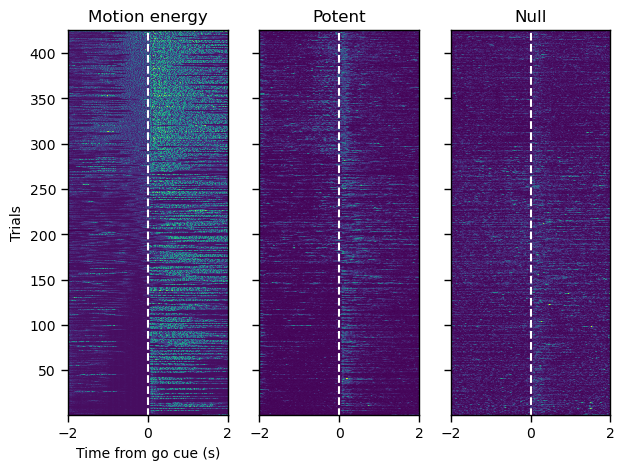

In [98]:
## PLOT

# % plot motion energy, potent ssm, null ssm

# % sort trials by average motion energy in late delay epoch
sortTimes = [-0.505, -0.005]; # in seconds, relative to go cue
ix = []
for i in range(len(sortTimes)):
    ix.append(np.argmin(np.abs(time - sortTimes[i])))

sortix = np.argsort(np.mean(motionEnergy[ix[0]:ix[1],:],axis=0))

xlims = [-2 , 2]
ylims = [1 , nTrials]

f, axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(7,5))
axs[0].set_xlabel("Time from go cue (s)")
axs[0].set_ylabel("Trials")


# # % plot motion energy
ax = axs[0]
ax.set_title('Motion energy')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.tick_params('both', length=5, width=1, which='major')
ax.pcolormesh(time, np.arange(nTrials), motionEnergy[:,sortix].T, shading='nearest')
ax.vlines(0,0,nTrials,colors='w',linestyle='--')
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# # % plot potent
ax = axs[1]
ax.set_title('Potent')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.tick_params('both', length=5, width=1, which='major')
ax.pcolormesh(time, np.arange(nTrials), potent_ssm[:,sortix].T, shading='nearest')
ax.vlines(0,0,nTrials,colors='w',linestyle='--')
ax.set_xlim(xlims)
ax.set_ylim(ylims)


# # % plot null
ax = axs[2]
ax.set_title('Null')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.tick_params('both', length=5, width=1, which='major')
ax.pcolormesh(time, np.arange(nTrials), null_ssm[:,sortix].T, shading='nearest')
ax.vlines(0,0,nTrials,colors='w',linestyle='--')
ax.set_xlim(xlims)
ax.set_ylim(ylims)

plt.show()

